# Data Cleaning on PG&E Energy Consumption

This notebook is dedicated for cleaning the available energy data sets and brining them to format appropriate for regression modellings.

### Importing require packages:

In [74]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import glob
from bokeh.io import push_notebook, output_notebook, show
from bokeh.plotting import figure
output_notebook()

Loading BokehJS ...

### Data Explanation:

There are 40 csv files available, 20 for gas consumption and 20 for electricity consumption.
Data is available for all quarters for 5 years from 2013 to 2017.

The columns are:

- ``ZipCode``: the location of the energy customer
- ``Month``: month of the year
- ``Year``: year of measurement
- ``CustomerClass``: categorical with four levels (1) residential, (2) commercial, (3) agricultural, and (4) industrial.
- ``Combined``: If zipcode is not large enough. It is categorical with two class, Yes and No. 
- ``TotalCustomers``: number of customers consuming energy in that zip code.
- ``TotalKwh``: total KWh used **available for electrical energy data**
- ``TotalThm``: total gas usage ** available for gas energy data**

### Data Import

We use globe package to import the name of all the csv file into a list.

In [4]:
pattern_elec = 'data/*ElectricUsageByZip.csv'
pattern_gas = 'data/*GasUsageByZip.csv'
elec_csv_files = glob.glob(pattern_elec) # allows importing file name for wild cards
gas_csv_files = glob.glob(pattern_gas) # allows importing file name for wild cards

The following code block will perform this actions:
    
- Concatanating all the electricity data frames into one
- Lower casing the column names (some csv files have uppoer case column names)
- Cleaing customer class name to only contain industrial/commericial/residential/agricultural
- Cleaning total kiloWatt power into integer value
- Cleaning total number of customers into integer value
- Removing areas without customers [totalcustomers == 0]
- Getting the logarithm of the power consumption as it is extremely diverse

In [69]:
electricity_list = []
for indx, file in enumerate(elec_csv_files):
    temp_df = pd.read_csv(file)
    columns_list = temp_df.columns.values # some datasets have uppercase column name
    temp_df.columns = [x.lower() for x in columns_list]
    temp_df.customerclass = temp_df.customerclass.str[5:]
    temp_df.totalkwh = temp_df.totalkwh.str.replace(",","")
    temp_df.totalkwh = pd.to_numeric(temp_df.totalkwh)
    temp_df.totalcustomers = temp_df.totalcustomers.str.replace(",","")
    temp_df.totalcustomers = pd.to_numeric(temp_df.totalcustomers)
    temp_df.drop('averagekwh', axis = 1, inplace = True)
    temp_df['logenergy'] = np.log(temp_df.totalkwh)
    temp_df['class_factor'],_ = pd.factorize(temp_df.customerclass)
    electricity_list.append(temp_df)


electricity = pd.concat(electricity_list)
electricity = electricity.loc[electricity.totalcustomers != 0]
electricity.reset_index(drop = True, inplace=True)
electricity.head()

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: RuntimeWarning: divide by zero encountered in log


,zipcode,month,year,customerclass,combined,totalcustomers,totalkwh,logenergy,class_factor
0,93206,2,2013,Agricultural,Y,138,7249627,15.796461,0
1,93206,3,2013,Agricultural,Y,371,20354832,16.828829,0
2,93212,2,2013,Agricultural,Y,213,9971956,16.115287,0
3,93230,2,2013,Agricultural,Y,244,3942702,15.187377,0
4,93245,2,2013,Agricultural,N,334,1008626,13.824100,0


In [71]:
electricity.info()
electricity.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70911 entries, 0 to 70910
Data columns (total 9 columns):
zipcode           70911 non-null int64
month             70911 non-null int64
year              70911 non-null int64
customerclass     70911 non-null object
combined          70911 non-null object
totalcustomers    70911 non-null int64
totalkwh          70911 non-null int64
logenergy         70911 non-null float64
class_factor      70911 non-null int64
dtypes: float64(1), int64(6), object(2)
memory usage: 4.9+ MB


,zipcode,month,year,totalcustomers,totalkwh,logenergy,class_factor
count,70911.000000,70911.000000,70911.000000,70911.000000,7.091100e+04,70911.000000,70911.000000
mean,94816.959640,6.574213,2015.065251,4043.339073,5.590823e+06,14.438429,2.202592
std,836.445429,3.400285,1.419276,5541.616564,2.235160e+07,1.593642,1.071006
min,93201.000000,1.000000,2013.000000,16.000000,7.209000e+03,8.883086,0.000000
25%,94066.000000,4.000000,2014.000000,402.000000,6.001375e+05,13.304914,1.000000
50%,95023.000000,7.000000,2015.000000,1198.000000,2.639567e+06,14.786125,3.000000
75%,95482.000000,9.000000,2016.000000,5663.000000,6.243980e+06,15.647128,3.000000
max,96137.000000,12.000000,2017.000000,103680.000000,1.250439e+09,20.946760,3.000000


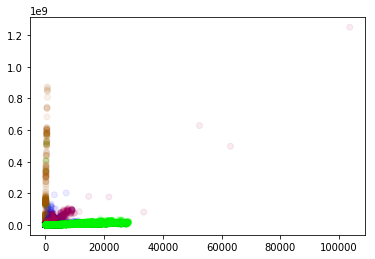

In [72]:
plt.scatter(electricity.totalcustomers, electricity.totalkwh, c = electricity.class_factor, cmap=plt.cm.brg, alpha = .08)
plt.show()